In [ ]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
import pylab
from bilby.core.prior import Uniform, Sine, Cosine, PowerLaw, Constraint
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.filter.matchedfilter import sigmasq
from pycbc.detector import Detector
from pycbc.psd import analytical
from pycbc.psd import read as psd_read    
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value
from scipy import integrate
from astropy import constants as const
%matplotlib inline

In [51]:
def calculate_snr(param_args, ifos_obj, psd_analytical=False, ra=2.2, dec=-1.25, pol=2.1, t_gps=120):
    sample_rate=1024
    apx='IMRPhenomD'
    f_lower=10
    hp, hc=get_td_waveform(approximant=apx,
                            mass1=param_args['mass_1'],
                            mass2=param_args['mass_2'],
                            spin1z=param_args['spin_1z'],
                            spin1x=param_args['spin_1x'],
                            spin1y=param_args['spin_1y'],
                            spin2z=param_args['spin_2z'],
                            spin2x=param_args['spin_2x'],
                            spin2y=param_args['spin_2y'],
                            inclination=param_args['theta_jn'],
                            coa_phase=param_args['phase'],
                            distance=param_args['luminosity_distance'],
                            f_lower=f_lower,
                            delta_t=1.0/sample_rate)


    flow = 10.0
    delta_f = 1.0 / hp.duration 
    flen = int(sample_rate/delta_f)
    if psd_analytical:
        psd = analytical.aLIGOZeroDetHighPower(flen, delta_f, flow) #optimize by calculating only once   
    else:
        read_data = np.genfromtxt('o3_h1.txt')
        psd_data = read_data[:, 1]
        psd_data = psd_data ** 2
        freq = read_data[:, 0]
        psd = psd_read.from_numpy_arrays(freq, psd_data,flen, delta_f, 20)
        psd.data[np.argwhere(psd.data == 0)] = 1
    gw = {'hp': hp, 'hc':hc, 'psd': psd}
    
    for det in ifos_obj:
        fp, fc=det.antenna_pattern(ra, dec, pol, t_gps)
    
        s= fp * gw['hp'] + fc * gw['hc']
        snr = sigmasq(s,psd=gw['psd'], low_frequency_cutoff=10)
        if 'snr_sq' in gw:  
            gw['snr_sq'] += snr
        else:
            gw['snr_sq'] = snr
            
    return np.sqrt(gw['snr_sq'])

def max_distance(param_args, ifos_obj, ra_lst, dec_lst, theta_jn_lst, snr_thres=8, psd_analytical=False):
    max_distance_opt=list() 
    for i in range(n):
        param_args['luminosity_distance']=1
        if (i%(100) == 0):
                print(i)
        param_args['theta_jn']=theta_jn_lst[i] 
        while True:
            param_args['theta_jn']=theta_jn_lst[i] 
            snr=calculate_snr(param_args, ifos_det, ra=ra_lst[i], dec=dec_lst[i])   
            if snr < 8:
                max_distance_opt.append(param_args['luminosity_distance'])
                break
            if snr >= 16:
                param_args['luminosity_distance']= param_args['luminosity_distance'] * (snr/8)
            else:
                param_args['luminosity_distance']+=10
    return max_distance_opt

def calculate_sens_vol(max_dist_lst, integral, dl, n):
    inds = (np.digitize(max_dist_lst,dl))
    sum_total = 0 

    for i in inds:
        sum_total += integral[i]

    h0 = Planck15.H(0)
    volume_sens = (1*u.year)*(const.c/h0)*4*np.pi*sum_total/n
    return (volume_sens * (u.km / (1e3 * u.m)) * (u.Gpc**3/(1e9*u.Mpc**3)))
    

In [99]:
#set up ifos objects
ifos=['H1', 'L1', 'V1']
ifos_det = []

for ifo in ifos:
    ifos_det.append(Detector(ifo))
    

In [40]:
dl = np.arange(1, 10000, 10)
z_lst = list()
for i in dl:
    z_lst.append(z_at_value(Planck15.luminosity_distance, i*u.Mpc).value)
    
cosmo_lst = list()
for z in z_lst:
    e = Planck15.efunc(z)
    cosmo_lst.append(1/(e*(1+z)**3))

kernel = cosmo_lst * (dl**2)
integral = integrate.cumtrapz(kernel, x=z_lst) * u.Mpc ** 2

In [28]:
prior=dict(dec=Cosine(name='dec'),
           ra=Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic'),
           theta_jn=Sine(name='theta_jn'))
param_args = dict(mass_1=35,
                  mass_2=35,
                  spin_1z=0,
                  spin_1x=0,
                  spin_1y=0,
                  spin_2z=0,
                  spin_2x=0,
                  spin_2y=0,
                  phase=0,
                  luminosity_distance=1)

In [44]:
#create samples for ra, dec and inclination
n=500
ra_lst=prior['ra'].sample(n)
dec_lst=prior['dec'].sample(n)
theta_jn_lst=prior['theta_jn'].sample(n)

In [45]:
#optimized minimum distance function
param_args['luminosity_distance']=1
max_distance_opt_500_samples=max_distance(param_args, ifos_det, ra_lst, dec_lst, theta_jn_lst)

0
100
200
300
400


In [47]:
print(f"{n} injections sensitive volume = {calculate_sens_vol(max_distance_opt_500_samples, integral, dl, n)}")

500 injections sensitive volume = 10.878283590364832 Gpc3 yr


In [ ]:
#create samples for ra, dec and inclination
n=1000
ra_lst=prior['ra'].sample(n)
dec_lst=prior['dec'].sample(n)
theta_jn_lst=prior['theta_jn'].sample(n)
param_args['luminosity_distance']=1
max_distance_opt_1000_samples=max_distance(param_args, ifos_det, ra_lst, dec_lst, theta_jn_lst)

In [49]:
print(f"{n} injections sensitive volume = {calculate_sens_vol(max_distance_opt_1000_samples, integral, dl, 1000)}")

1000 injections sensitive volume = 10.428555192998534 Gpc3 yr


In [ ]:
#create samples for ra, dec and inclination
n=2500
ra_lst=prior['ra'].sample(n)
dec_lst=prior['dec'].sample(n)
theta_jn_lst=prior['theta_jn'].sample(n)
param_args['luminosity_distance']=1
max_distance_opt_2500_samples=max_distance(param_args, ifos_det, ra_lst, dec_lst, theta_jn_lst)

In [52]:
print(f"{n} injections sensitive volume = {calculate_sens_vol(max_distance_opt_2500_samples, integral, dl, 2500)}")

2500 injections sensitive volume = 10.436689029134676 Gpc3 yr


In [56]:
#create samples for ra, dec and inclination
n=500
ra_lst=prior['ra'].sample(n)
dec_lst=prior['dec'].sample(n)
theta_jn_lst=prior['theta_jn'].sample(n)
param_args['luminosity_distance']=1
max_distance_opt_500_samples_wovirgo=max_distance(param_args, ifos_det, ra_lst, dec_lst, theta_jn_lst)

0
100
200
300
400


In [57]:
print(f"{n} injections sensitive volume = {calculate_sens_vol(max_distance_opt_500_samples_wovirgo, integral, dl, 500)}")

500 injections sensitive volume = 7.192096684992272 Gpc3 yr


(array([24., 11., 16., 20., 13., 18., 20., 17., 15., 14., 10., 10., 11.,
        18., 17., 15., 13., 18., 13., 17., 20., 16., 12., 12., 15., 11.,
        17., 16., 16., 16., 15., 24.]),
 array([3.06309711e-03, 1.98677109e-01, 3.94291122e-01, 5.89905134e-01,
        7.85519146e-01, 9.81133159e-01, 1.17674717e+00, 1.37236118e+00,
        1.56797520e+00, 1.76358921e+00, 1.95920322e+00, 2.15481723e+00,
        2.35043125e+00, 2.54604526e+00, 2.74165927e+00, 2.93727328e+00,
        3.13288729e+00, 3.32850131e+00, 3.52411532e+00, 3.71972933e+00,
        3.91534334e+00, 4.11095736e+00, 4.30657137e+00, 4.50218538e+00,
        4.69779939e+00, 4.89341341e+00, 5.08902742e+00, 5.28464143e+00,
        5.48025544e+00, 5.67586945e+00, 5.87148347e+00, 6.06709748e+00,
        6.26271149e+00]),
 <BarContainer object of 32 artists>)

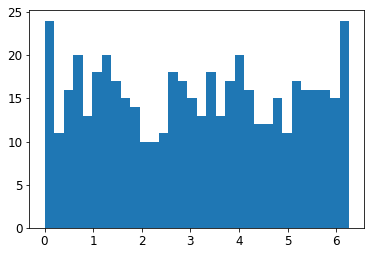

In [60]:
pylab.hist(ra_lst, bins=32)

(array([ 9., 19., 16., 40., 30., 52., 44., 41., 55., 44., 44., 31., 28.,
        22., 15., 10.]),
 array([-1.50555679, -1.31812605, -1.13069531, -0.94326456, -0.75583382,
        -0.56840308, -0.38097234, -0.1935416 , -0.00611085,  0.18131989,
         0.36875063,  0.55618137,  0.74361211,  0.93104286,  1.1184736 ,
         1.30590434,  1.49333508]),
 <BarContainer object of 16 artists>)

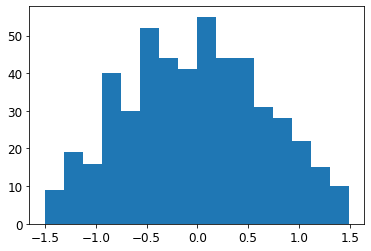

In [61]:
pylab.hist(dec_lst, bins=16)

In [70]:
n=5000
ra_lst=prior['ra'].sample(n)
dec_lst=prior['dec'].sample(n)
theta_jn_lst=prior['theta_jn'].sample(n)
snr_lst = list()
param_args['luminosity_distance']=1
for i in range(n):
    param_args['theta_jn']=theta_jn_lst[i] 
    snr=calculate_snr(param_args, ifos_det, ra=ra_lst[i], dec=dec_lst[i])        
    snr_lst.append(snr)

In [83]:
ra_bins = np.arange(0, 2*np.pi, 2*np.pi/32)
dec_bins = np.arange(-np.pi/2, np.pi/2, np.pi/16)

r = np.digitize(ra_lst, ra_bins)
d = np.digitize(dec_lst, dec_bins)

matrix = np.zeros((16, 32))
i = 0
for ra_ind, dec_ind in zip(r, d):
    matrix[dec_ind-1, ra_ind-1] +=  snr_lst[i]
    i+=1
    

In [93]:
bins_normalize = np.histogram2d(ra_lst, dec_lst, [16, 32])
norm = bins_normalize[0]
norm = np.where(norm == 0, 1, norm)

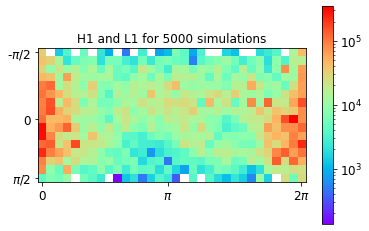

In [122]:
from matplotlib import cm
from matplotlib import colors
pylab.imshow(matrix/norm, cmap=cm.rainbow, interpolation='nearest', norm=colors.LogNorm())
pylab.title("H1 and L1 for 5000 simulations")
pylab.yticks([0, 8, 15], ['-$\pi$/2', '0', '$\pi$/2'])
pylab.xticks([0, 15, 31], ['0', '$\pi$', '2$\pi$' ])
pylab.colorbar()
#y axis = dec bins, x axis = ra bins


In [100]:
n=5000
ra_lst_V1=prior['ra'].sample(n)
dec_lst_V1=prior['dec'].sample(n)
theta_jn_lst_V1=prior['theta_jn'].sample(n)
snr_lst_V1= list()
param_args['luminosity_distance']=1
for i in range(n):
    param_args['theta_jn']=theta_jn_lst_V1[i] 
    snr=calculate_snr(param_args, ifos_det, ra=ra_lst_V1[i], dec=dec_lst_V1[i])        
    snr_lst_V1.append(snr)

In [101]:
r_V1 = np.digitize(ra_lst_V1, ra_bins)
d_V1 = np.digitize(dec_lst_V1, dec_bins)

matrix_V1 = np.zeros((16, 32))
i = 0
for ra_ind, dec_ind in zip(r_V1, d_V1):
    matrix_V1[dec_ind-1, ra_ind-1] +=  snr_lst_V1[i]
    i+=1

bins_normalize_V1 = np.histogram2d(ra_lst_V1, dec_lst_V1, [16, 32])
norm_V1 = bins_normalize_V1[0]
norm_V1 = np.where(norm_V1 == 0, 1, norm_V1)


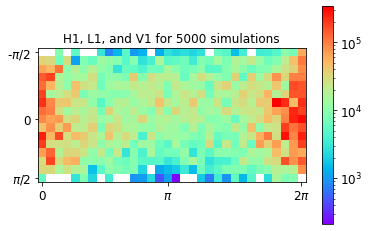

In [121]:
pylab.imshow(matrix_V1/norm_V1, cmap=cm.rainbow, interpolation='nearest', norm=colors.LogNorm())
pylab.title("H1, L1, and V1 for 5000 simulations")
pylab.yticks([0, 8, 15], ['-$\pi$/2', '0', '$\pi$/2'])
pylab.xticks([0, 15, 31], ['0', '$\pi$', '2$\pi$' ])
pylab.colorbar()
#y axis = dec bins, x axis = ra bins

In [105]:
print(f"Average snr at distance 1Mpc with virgo: {np.sum(snr_lst_V1)/len(snr_lst_V1)}")
print(f"Average snr at distance 1Mpc without virgo: {np.sum(snr_lst)/len(snr_lst)}")

Average snr at distance 1Mpc with virgo: 14754.157356000815
Average snr at distance 1Mpc without virgo: 11692.57780758574
